In [1]:
%load_ext autoreload
%autoreload 2

# Sensor Calibration

The goal here is to fit the response function of the sensor your camera uses. This is needed so that we are able to obtain linear measurement for further processing of the images

## Background

This is a modern implementation of https://www.pauldebevec.com/Research/HDR/debevec-siggraph97.pdf
It has been made to work with high-bit depth sensors. The original paper struggles with more than 8. 

## Setup

The goal is to put your camera on a tripod and take many pictures of the same scene at different exposure times. See the paper for more details but 15-20 images should be good, but I personally run it on up to 50 with 1/3 stop in between to really have good data.
Try to aim for a scene for with of each colors so that we can calibrate each channel. Try to avoid scenes with too much high dynamic range as most pixels will only have saturated pixels otherwise

### Settings

Enter your information below (should be self explanatory)

In [2]:
IMAGE_FOLDER = '/data/keoscope/calibration_R6mk2/sensor_measurements'
OUTPUT_CALIBRATION_FILE = '/data/keoscope/calibration_R6mk2/sensor_response.npy'
IMAGE_EXTENSION = 'CR3'
NUM_ITERS = 150
BATCH_SIZE = 30_000

### Imports

In [3]:
from glob import glob
from os import path, makedirs
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from mirrorSDF.utils.image import imread
from mirrorSDF.optical_models import RGBImageSensor

/home/guillaumeleclerc/mirrorSDF/mirrorSDF/optical_models/sensor/rgb_image_sensor.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Loading Images

In [4]:
image_filenames = glob(path.join(IMAGE_FOLDER, f'*.{IMAGE_EXTENSION}'))
loaded_images, exposures = zip(*[imread(file_name) for file_name in tqdm(image_filenames)])
loaded_images = np.stack(loaded_images, 2)
exposures = np.array(exposures)

if len(set(exposures.tolist())) != len(exposures):
    raise ValueError('Images with identical Exposures!')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:24<00:00,  1.40it/s]


### Fitting the sensor response

Best if your loss is around 1e-5, but that's probably not super critical. You might require a good camera and a lot of shots to achieve this accuracy. One should expect a lower loss for the green channel as most sensors have twice as many green pixels as red or blues. This is a good sanity check to know that it worked well.

In [5]:
sensor = RGBImageSensor.calibrate_from_measurements(loaded_images, exposures,
                                                    n_iterations=NUM_ITERS, batch_size=BATCH_SIZE)
response_red, response_green, response_blue = sensor.curves

Calibrating channels:   0%|          | 0/3 [00:00<?, ?it/s]

Calibrating:   0%|          | 0/150 [00:00<?, ?it/s]

Calibrating:   0%|          | 0/150 [00:00<?, ?it/s]

Calibrating:   0%|          | 0/150 [00:00<?, ?it/s]

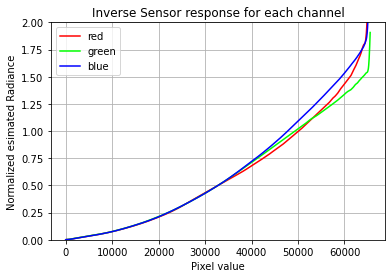

In [6]:
plt.plot(response_red, color='#F00', label='red')
plt.plot(response_green, color='#0F0', label='green')
plt.plot(response_blue, color='#00F', label='blue')
plt.title('Inverse Sensor response for each channel')
plt.ylabel('Normalized esimated Radiance')
plt.xlabel('Pixel value')
plt.grid()
plt.ylim(0, 2)
plt.legend()

### Writing the sensor calibration

In [7]:
makedirs(path.dirname(OUTPUT_CALIBRATION_FILE), exist_ok=True)
sensor.to_disk(OUTPUT_CALIBRATION_FILE)